# Data loading

In [1]:
from pyspark.sql.functions import to_timestamp, col
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import pandas_udf
import pandas as pd
import numpy as np

EARTH_RADIUS = 6378  # km

# Allow 4 GB of memory for the driver
spark = SparkSession.builder \
    .appName("LongestRoute") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", 1000) \
    .getOrCreate()


# Load the CSV file into a DataFrame
# data_path = "../lab1/data/aisdk-test.csv"
data_path = "data/aisdk-2024-05-04.csv"

df = spark.read.csv(data_path, header=True, inferSchema=True)

# Convert the '# Timestamp' column to TimestampType
df = df.withColumn("Timestamp", to_timestamp(col("# Timestamp"), "dd/MM/yyyy HH:mm:ss"))

# Keep only these columns: Timestamp, MMSI, Latitude, Longitude
df = df.select("Timestamp", "MMSI", "Latitude", "Longitude")

# disply the schema of the DataFrame
df.printSchema()

# print the length of the DataFrame
print(f"Length of DataFrame: {df.count()}")

# Remove rows with null values in any of the columns
df = df.dropna()

# print the length of the DataFrame after dropping null values
print(f"Length of DataFrame after dropping null values: {df.count()}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/05/29 15:54:32 WARN Utils: Your hostname, DESKTOP-QJASGSB, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/29 15:54:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/29 15:54:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- Timestamp: timestamp (nullable = true)
 |-- MMSI: integer (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



Length of DataFrame: 19175663


Length of DataFrame after dropping null values: 19175663


# Data Processing

### Check latitude and longitude ranges

In [2]:
# Print max latitude and longitude
max_lat = df.agg({"Latitude": "max"}).collect()[0][0]
max_lon = df.agg({"Longitude": "max"}).collect()[0][0]
print(f"Max Latitude: {max_lat}, Max Longitude: {max_lon}")
# Print min latitude and longitude
min_lat = df.agg({"Latitude": "min"}).collect()[0][0]
min_lon = df.agg({"Longitude": "min"}).collect()[0][0]
print(f"Min Latitude: {min_lat}, Min Longitude: {min_lon}")

Max Latitude: 91.0, Max Longitude: 161.236383


Min Latitude: 0.433498, Min Longitude: -9.226323


In [3]:
# print how many rows have latitude above 90
rows_above_90 = df.filter(col("Latitude") > 90).count()
print(f"Rows with Latitude above 90: {rows_above_90}")

# How many unique MMSI values in rows_above_90
unique_mmsi_above_90 = df.filter(col("Latitude") > 90).select("MMSI").distinct().count()
print(f"Unique MMSI values in rows with Latitude above 90: {unique_mmsi_above_90}")

Rows with Latitude above 90: 24272


Unique MMSI values in rows with Latitude above 90: 1095


In [4]:
# Remove rows with latitude above 90
df = df.filter(col("Latitude") <= 90)

### Preparation

groupby MMSI and order by timestamp, then include the next location latitude, longtitude and timestamp for each row

In [5]:
df = df.withColumn("Latitude", F.radians("Latitude"))
df = df.withColumn("Longitude", F.radians("Longitude"))

window = Window.partitionBy("MMSI").orderBy("Timestamp")

df = df.withColumn("prev_lat", F.lag("Latitude").over(window))
df = df.withColumn("prev_lon", F.lag("Longitude").over(window))
df = df.withColumn("prev_Timestamp", F.lag("Timestamp").over(window))


In [6]:
# Sanity check: ensure a 1 null per MMSI

na_count = df.filter(
    col("prev_lat").isNull() |
    col("prev_lon").isNull() | 
    col("prev_Timestamp").isNull()
).count()

print(f"Rows with nulls: {na_count}")
print(f"Distinct MMSI: {df.select('MMSI').distinct().count()}")

Rows with nulls: 5575


Distinct MMSI: 5575


In [7]:
# Remove the the null values (one per MMSI)
df = df.dropna(subset=["prev_lat", "prev_lon"])

## Calculate the distance

In [8]:
@pandas_udf(DoubleType())
def haversine_radians(lat1: pd.Series, lon1: pd.Series, lat2: pd.Series, lon2: pd.Series) -> pd.Series:
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return EARTH_RADIUS * c


In [9]:
# Calculate the distance
df = df.withColumn("distance", haversine_radians(
    F.col("Latitude"), F.col("Longitude"),
    F.col("prev_lat"), F.col("prev_lon")
)).persist()

In [10]:
# Aggregate the distances by MMSI and show the maximum distance
df_total = df.groupBy("MMSI").agg(F.sum("distance").alias("total_distance"))
longest_route = df_total.orderBy(F.desc("total_distance")).limit(1)
longest_route.show()

+---------+-----------------+
|     MMSI|   total_distance|
+---------+-----------------+
|219000962|91568.18766608107|
+---------+-----------------+



## Distance calculation notes

Without memory offloading to disk using (`persist()`), spark runs out of memory:
<br>
> 
    Exception in thread "RemoteBlock-temp-file-clean-thread" java.lang.OutOfMemoryError: Java heap space
    25/05/29 11:42:50 WARN TaskMemoryManager: Failed to allocate a page (524288 bytes), try again.
<br>
<br>


Without restriced memory (`.config("spark.driver.memory", "4g") \`) does not fit cache into memory and writes into disk. Produces warnings like this one:
<br>

>
    25/05/29 11:47:16 WARN MemoryStore: Not enough space to cache rdd_58_79 in memory! (computed 3.9 MiB so far) 
    25/05/29 11:47:16 WARN BlockManager: Persisting block rdd_58_79 to disk instead


# Filtering

The total distance is huge, let's filter the vessels by speed and sudden jumps

### Find MMSI with speed to big

In [44]:
SPEED_THRESHOLD = 500  # 'Spirit of Australia' boat record speed in km/h, faster even than helicopter

# Calculate the time difference in seconds
df = df.withColumn("time_diff", 
                   (F.col("Timestamp").cast("long") - F.col("prev_Timestamp").cast("long")))

# Calculate the speed in km/h
df = df.withColumn("speed", 
                   F.when(F.col("time_diff") > 0, 
                          (F.col("distance") / F.col("time_diff")) * 3600).otherwise(0))

# Show the top speeds
max_speed = df.groupBy("MMSI").agg(F.max("speed").alias("max_speed"))
max_speed = max_speed.orderBy(F.desc("max_speed"))
max_speed.limit(5).show()

+---------+--------------------+
|     MMSI|           max_speed|
+---------+--------------------+
|992111851|1.0847190754747417E7|
|219000962|   8237218.904234478|
|305036000|   4487706.692623429|
|266460000|   3735183.862427563|
|255806476|   2307281.642306903|
+---------+--------------------+



In [45]:
# Get the MMSI that has bigger speed than the threshold
high_speed_mmsi = max_speed.filter(F.col("max_speed") > SPEED_THRESHOLD).select("MMSI")
high_speed_mmsi.count()

404

### Find MMSI with sudden jumps

In [46]:
# For the time_diff = 0, show the distances
zero_time_diff = df.filter(F.col("time_diff") == 0)
zero_time_diff.select("MMSI", "Timestamp", "distance", "time_diff").orderBy(F.desc("distance")).show(5)

+---------+-------------------+------------------+---------+
|     MMSI|          Timestamp|          distance|time_diff|
+---------+-------------------+------------------+---------+
|992111851|2024-05-04 06:15:36| 6026.217085970787|        0|
|266460000|2024-05-04 18:56:23|3112.6517714155084|        0|
|218816000|2024-05-04 21:32:12|3108.2089704214786|        0|
|218816000|2024-05-04 21:32:12|3108.2089704214786|        0|
|563074600|2024-05-04 23:44:44| 1462.095225273255|        0|
+---------+-------------------+------------------+---------+
only showing top 5 rows


In [ ]:
# Get the MMSI that has zero time difference and a distance geater than 1
# Meaning it jumped more than 1 km in 0 seconds
zero_time_diff_mmsi = zero_time_diff.filter(F.col("distance") > 1).select("MMSI").distinct()
zero_time_diff_mmsi.count()

21

### Filter the results and produce final output

In [48]:
# Remove the high speed mmsi from 'df_total'
df_total_filtered = df_total.join(high_speed_mmsi, on="MMSI", how="left_anti")

# Remove the sudden jumps in zero time difference from 'df_total_filtered'
df_total_filtered = df_total_filtered.join(zero_time_diff_mmsi, on="MMSI", how="left_anti")

# Show the longest route after filtering out high speed MMSI
longest_route_filtered = df_total_filtered.orderBy(F.desc("total_distance")).limit(10)
longest_route_filtered.show()

+---------+-----------------+
|     MMSI|   total_distance|
+---------+-----------------+
|219133000|793.6929981047765|
|230007000|  739.58325628029|
|636017000|719.0057649888952|
|308803000| 709.981485328393|
|244874000| 685.002795106738|
|636018490|677.2374536682871|
|230350000| 652.875358918316|
|257182000|650.3570832881265|
|354540000|643.8255820359683|
|277399000|636.4836939538918|
+---------+-----------------+



In [49]:
# Show the longest_route_filtered along with their speeds
longest_route_filtered = longest_route_filtered.join(max_speed, on="MMSI", how="inner")
longest_route_filtered = longest_route_filtered.orderBy(F.desc("total_distance"))
longest_route_filtered.select("MMSI", "total_distance", "max_speed").show()

+---------+-----------------+------------------+
|     MMSI|   total_distance|         max_speed|
+---------+-----------------+------------------+
|219133000|793.6929981047765| 457.9871766060948|
|230007000|  739.58325628029| 382.5326478484258|
|636017000|719.0057649888952|393.10882746936676|
|308803000| 709.981485328393| 358.9479569856432|
|244874000| 685.002795106738|229.39710526604875|
|636018490|677.2374536682871| 200.5910982493852|
|230350000| 652.875358918316| 258.6723715405454|
|257182000|650.3570832881265| 394.8183889309251|
|354540000|643.8255820359683|253.84739280214254|
|277399000|636.4836939538918|367.31211031850665|
+---------+-----------------+------------------+



The top distance ship '219133000' with distnace of 793.6 km

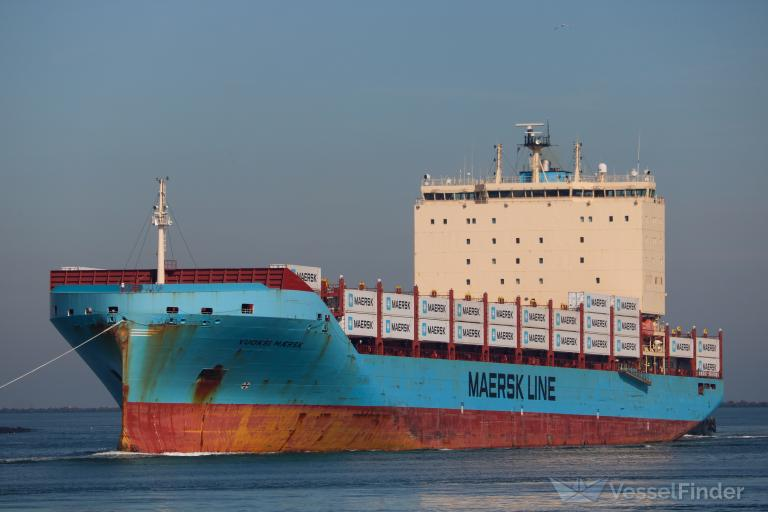